In [2]:
import torch
from torch import nn, Tensor

import matplotlib.pyplot as plt
#  from sklearn.datasets import make_moons

In [3]:
import numpy as np

def generate_square_points(n_points=256, side_length=2.0):
    points_per_side = n_points // 4
    half = side_length / 2

    # Lati: sinistra → sopra → destra → sotto
    left = torch.stack([
        torch.full((points_per_side,), -half),
        torch.linspace(-half, half, points_per_side)
    ], dim=1)

    top = torch.stack([
        torch.linspace(-half, half, points_per_side),
        torch.full((points_per_side,), half)
    ], dim=1)

    right = torch.stack([
        torch.full((points_per_side,), half),
        torch.linspace(half, -half, points_per_side)
    ], dim=1)

    bottom = torch.stack([
        torch.linspace(half, -half, points_per_side),
        torch.full((points_per_side,), -half)
    ], dim=1)

    square = torch.cat([left, top, right, bottom], dim=0)
    return square


import numpy as np
import torch

def generate_circle_points(n_samples=256):
    points = []

    # Ellisse (testa)
    t = np.linspace(0, 2*np.pi, 1000)

    # Cerchio destro
    x3 = 1.4 * np.cos(t) + 1.5
    y3 = 1.4 * np.sin(t) - 1.0
    circle_right = np.stack([x3, y3], axis=1)
    points.append(np.stack([x3, y3], axis=1))

    # Tutti i punti insieme
    all_points = np.concatenate(points, axis=0)

    # Normalizza in [-1, 1] per coerenza con solito spazio
    min_vals = all_points.min(axis=0)
    max_vals = all_points.max(axis=0)
    normalized = 2 * (all_points - min_vals) / (max_vals - min_vals) - 1

    # Campiona n_samples punti a caso
    idx = np.random.choice(len(normalized), n_samples, replace=False)
    sampled_points = normalized[idx]

    return torch.tensor(sampled_points, dtype=torch.float32)


In [4]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)

        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

In [5]:
import torch

# Elenco dei dispositivi disponibili
devices = torch.cuda.device_count()
if devices > 0:
    for i in range(devices):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA devices available.")

Device 0: Tesla T4


In [6]:
from tqdm import trange, tqdm

import os

CHECKPOINTS_PATH = 'checkpoints'
if not os.path.exists(CHECKPOINTS_PATH):
    os.makedirs(CHECKPOINTS_PATH)

def train_flow(flow: nn.Module, exp_name: str, n_epochs: int = 10000):
    if torch.cuda.is_available():
        print("Using", torch.cuda.get_device_name(0))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    flow.to(device)
    flow.train()
    
    optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
    criterion = nn.MSELoss()
    old_epoch = 0
    for e in trange(n_epochs):
        # a random flag to choose between circle and square
        figure = np.random.randint(0, 2)
        if figure == 0:
            x_1_base = generate_circle_points(256).to(device)
        else:
            x_1_base = generate_square_points(256).to(device)

        flag = torch.full((256, 1), float(figure)).to(device)

        # add a padding to x_1 of 1 dimension
        x_1 = torch.concat([x_1_base, flag], dim=1)
        x_0 = torch.concat([torch.randn_like(x_1_base), flag], dim=1)

        t = torch.rand(len(x_1), 1).to(device)
        x_t = (1 - t) * x_0 + t * x_1
        dx_t = x_1 - x_0

        optimizer.zero_grad()
        criterion(flow(t=t, x_t=x_t), dx_t).backward()
        optimizer.step()
        
        if e % 1000 == 0 or e == n_epochs - 1:
            torch.save({
                'epoch': e,
                'model_state_dict': flow.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{e}.pth')
            print(f"Epoch {e}: Checkpoint saved.")
            if os.path.exists(f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{old_epoch}.pth'):
                os.remove(f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{old_epoch}.pth')
            old_epoch = e
    print("Training complete.")

In [7]:
flow = Flow(3)
train_flow(flow, n_epochs=100000, exp_name='flow_2d')

Using Tesla T4


  0%|                                                               | 71/100000 [00:00<04:14, 393.06it/s]

Epoch 0: Checkpoint saved.


  1%|▋                                                            | 1131/100000 [00:01<02:22, 694.04it/s]

Epoch 1000: Checkpoint saved.


  2%|█▎                                                           | 2130/100000 [00:03<02:18, 705.82it/s]

Epoch 2000: Checkpoint saved.


  3%|█▉                                                           | 3090/100000 [00:04<02:16, 709.84it/s]

Epoch 3000: Checkpoint saved.


  4%|██▌                                                          | 4137/100000 [00:05<02:09, 741.41it/s]

Epoch 4000: Checkpoint saved.


  5%|██▉                                                          | 4820/100000 [00:06<02:14, 709.23it/s]


KeyboardInterrupt: 

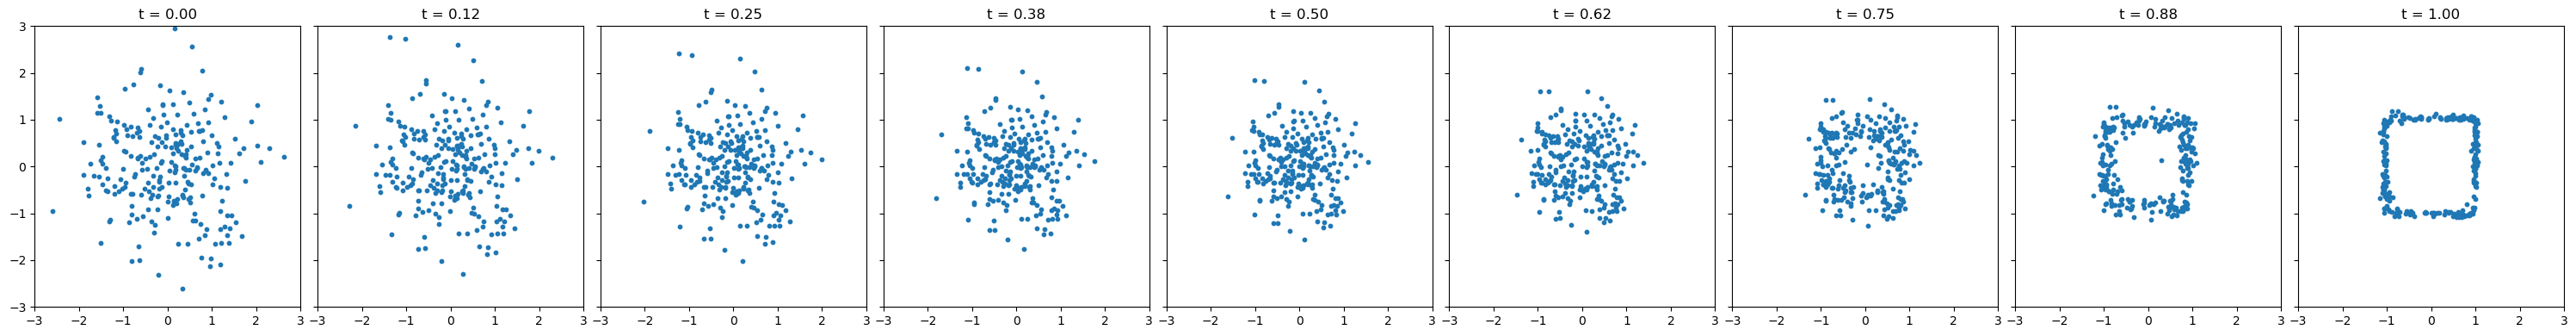

In [ ]:
import matplotlib.pyplot as plt
import torch

figure = 1  # 0 for circle, 1 for square
flag = torch.full((256, 1), float(figure))

# genera rumore iniziale + flag
x = torch.randn(256, 2)
x = torch.cat([x, flag], dim=1)

# evoluzione temporale
n_steps = 8
time_steps = torch.linspace(0, 1.0, n_steps + 1)

fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
axes[0].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10) 
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    # separa posizioni e flag
    pos = x[:, :2]
    flag = x[:, 2:]

    # applica un singolo step temporale
    pos = flow.step(x_t=torch.cat([pos, flag], dim=1),
                    t_start=time_steps[i],
                    t_end=time_steps[i + 1])[:, :2]

    # ricombina posizioni e flag per lo step successivo
    x = torch.cat([pos, flag], dim=1)

    axes[i + 1].scatter(pos[:, 0].detach(), pos[:, 1].detach(), s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()
